<a href="https://colab.research.google.com/github/BautistaDavid/Machine-Learning-Class-2022/blob/main/parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parcial

Nombres: David Felipe Bautista - Lina Chaparro - Johan chindoy


In [ ]:
#Estadistica
from scipy.spatial.distance import mahalanobis
from scipy.stats import chi2
import numpy as np

#Manejo de datos 
import pandas as pd

#SQL
import psycopg2 as ps

#Adicionales
import warnings
warnings.filterwarnings('ignore')

#Plots
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import folium
from folium import plugins
import io
from PIL import Image

#skelarn 
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## **Importamos datos usando SQL y Pandas**

In [ ]:
host_name = 'database-usta.cuxqvtybmzzt.us-east-2.rds.amazonaws.com'
dbname = 'database-usta'
port = '5432'
username = 'postgres'
password = '1234ob5678'

In [ ]:
try:
  conn = ps.connect(host=host_name, 
            user=username, 
            password=password)
except ps.OperationalError as e:
  raise e
else:
  print('Connected')

Connected


In [ ]:
df = pd.read_sql('select * from turismo', con=conn)

In [ ]:
df.head()

,id,sexo,edad,parentesco_jefe_hogar,viaje,motivo_viaje,monto_ultimo_viaje,leer_escribir,nivel_educativo,grado_alcanzado,diploma_obtenido,ingreso_mensual_aprox,num_noches,area
0,0,mujer,56,jefe_hogar,no,NULL,999999.0,si,basica_primaria,5,NULL,880000.0,999999,ANTIOQUIA
1,1,mujer,25,hijo,no,NULL,999999.0,si,media,11,bachiller,880000.0,999999,ANTIOQUIA
2,2,mujer,1,nieto,NULL,NULL,999999.0,NULL,NULL,999999,NULL,880000.0,999999,ANTIOQUIA
3,3,mujer,39,jefe_hogar,no,NULL,999999.0,si,basica_secundaria,9,NULL,860000.0,999999,ANTIOQUIA
4,4,mujer,14,hijo,no,NULL,999999.0,si,basica_secundaria,8,NULL,860000.0,999999,ANTIOQUIA


## **Analisis Exploratorio de datos**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46296 entries, 0 to 46295
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     46296 non-null  int64  
 1   sexo                   46296 non-null  object 
 2   edad                   46296 non-null  int64  
 3   parentesco_jefe_hogar  46296 non-null  object 
 4   viaje                  46296 non-null  object 
 5   motivo_viaje           46296 non-null  object 
 6   monto_ultimo_viaje     46296 non-null  object 
 7   leer_escribir          46296 non-null  object 
 8   nivel_educativo        46296 non-null  object 
 9   grado_alcanzado        46296 non-null  int64  
 10  diploma_obtenido       46296 non-null  object 
 11  ingreso_mensual_aprox  46296 non-null  float64
 12  num_noches             46296 non-null  int64  
 13  area                   46296 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 4.9+ 

Podemos ver queno hay datos nulos explixitos, sin embargo algunas columnas contienen respuestas que podriamos considerar como nulas... Vamos a observar los valores unicos en cada columna para identificar posibles nulos 

####**Manejo de datos atipicos y nulos**

In [ ]:
for col in df.columns:
  print(col)
  print(' ')
  print(df[col].unique())
  print('------'*10)

id
 
[    0     1     2 ... 46293 46294 46295]
------------------------------------------------------------
sexo
 
['mujer' 'hombre']
------------------------------------------------------------
edad
 
[ 56  25   1  39  14   9  68  34  21   5  11  36  30  15  12  28  29  55
  40  35  13  72  37  64  65  46  85  24   8  43  50  52  16  71  60  54
  32  58   3  27  26  23  10   7   0  42  17  20  38  75  62  18  19  47
  22  59  51  57  45   2  48   6  66  31  67  33  70  69  44  63  49  41
  61  79   4  88  53  77  73  86  96  82  78  80  91  84  74  81  83  76
  89  92  87  97  98  93  94  90  95 102 100  99 105]
------------------------------------------------------------
parentesco_jefe_hogar
 
['jefe_hogar' 'hijo' 'nieto' 'pareja' 'otro_pariente' 'otro_no_pariente'
 'pensionista' 'empleado_domestico' 'trabajador']
------------------------------------------------------------
viaje
 
['no' 'NULL' 'si']
------------------------------------------------------------
motivo_viaje
 
['NULL'

Ahora podemos conocer en que columnas se encuentran tanto datos atipicos como nulos, a continuacion los corregiremos en su toalidad. Antes de esto filtraremos el dataframe con las columnas utiles para el desarollo del resto del parcial.

In [ ]:
df.columns 

Index(['id', 'sexo', 'edad', 'parentesco_jefe_hogar', 'viaje', 'motivo_viaje',
       'monto_ultimo_viaje', 'leer_escribir', 'nivel_educativo',
       'grado_alcanzado', 'diploma_obtenido', 'ingreso_mensual_aprox',
       'num_noches', 'area'],
      dtype='object')

In [ ]:
df = df.drop(columns=['id','leer_escribir','diploma_obtenido','grado_alcanzado'])

In [ ]:
# df = df.drop(columns=['id','leer_escribir','diploma_obtenido'])
df['sexo'].replace({'mujer':0,'hombre':1},inplace=True)

df['parentesco_jefe_hogar'].replace({'nieto':'otro_pariente','empleado_domestico':'otro_no_pariente','pensionista':'otro_no_pariente',
                                     'empleado_domestico':'otro_no_pariente','trabajador':'otro_no_pariente'},inplace=True)
df = pd.concat([df,pd.get_dummies(df['parentesco_jefe_hogar'])],axis=1)
df = df.drop(columns=['parentesco_jefe_hogar','otro_no_pariente'])

df['viaje'].replace({'no':0,'si':1},inplace=True)
df = df[df['viaje']!='NULL']

df.drop(index = df[(df['viaje'] == 1) & (df['motivo_viaje'] == 'NULL')]['motivo_viaje'].index,inplace = True) # eliminando registros de personas que viajaron pero tienen null en motivo ... 124 registros 

df['nivel_educativo'].replace({'superior_universitaria':15,'media':9,'basica_secundaria':11,'basica_primaria':5,'ninguno':0,'no_sabe_no_informa':0,'preescolar':2,'niguno':0},inplace=True)

df['monto_ultimo_viaje'].replace({'999999.0':0},inplace=True)
df['monto_ultimo_viaje'] = df['monto_ultimo_viaje'].astype('float')

df['num_noches'].replace({999999:0},inplace=True)
df['area'] = df['area'].str.capitalize()

cols_int = ['viaje','hijo','jefe_hogar','otro_pariente','pareja']
for col in cols_int:
  df[col] = df[col].astype('int8')


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39712 entries, 0 to 46295
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   39712 non-null  int64  
 1   edad                   39712 non-null  int64  
 2   viaje                  39712 non-null  int8   
 3   motivo_viaje           39712 non-null  object 
 4   monto_ultimo_viaje     39712 non-null  float64
 5   nivel_educativo        39712 non-null  int64  
 6   ingreso_mensual_aprox  39712 non-null  float64
 7   num_noches             39712 non-null  int64  
 8   area                   39712 non-null  object 
 9   hijo                   39712 non-null  int8   
 10  jefe_hogar             39712 non-null  int8   
 11  otro_pariente          39712 non-null  int8   
 12  pareja                 39712 non-null  int8   
dtypes: float64(2), int64(4), int8(5), object(2)
memory usage: 2.9+ MB


#### **Analisis de Outliers**

In [ ]:
df_numerical = df[['edad','monto_ultimo_viaje','ingreso_mensual_aprox','num_noches']]

In [ ]:
mahal_distances = []

for row in df_numerical.to_numpy():
  mahal_distances.append(mahalanobis(row, df_numerical.mean(), np.linalg.inv(np.cov(df_numerical.values.T))))

k = df.shape[0]

df['mahal_distances'] = mahal_distances 
df['p_value'] = 1 - chi2.cdf(df['mahal_distances'], k-1)


In [ ]:
print(f'DataFrame shape antes de eliminar outliers:{df.shape}')
df = df[df['p_value'] >  0.05]
print(f'DataFrame shape despues de eliminar outliers:{df.shape}')

DataFrame shape antes de eliminar outliers:(39712, 15)
DataFrame shape despues de eliminar outliers:(39712, 15)


#### **Analisis Duplicados**

In [ ]:
print(f'DataFrame shape antes de eliminar duplicados:{df.shape}')
df = df.drop_duplicates()
print(f'DataFrame shape despues de eliminar duplicados:{df.shape}')

DataFrame shape antes de eliminar duplicados:(39712, 15)
DataFrame shape despues de eliminar duplicados:(37981, 15)


#### **Descripcion estadistica**

In [ ]:
df_numerical.describe()

,edad,monto_ultimo_viaje,ingreso_mensual_aprox,num_noches
count,39712.000000,3.971200e+04,3.971200e+04,39712.000000
mean,39.059680,4.434985e+04,1.667239e+06,0.555676
std,19.505937,3.168801e+05,1.652241e+06,3.134640
min,10.000000,0.000000e+00,9.800000e+01,0.000000
25%,23.000000,0.000000e+00,8.260000e+05,0.000000
50%,36.000000,0.000000e+00,1.200000e+06,0.000000
75%,54.000000,0.000000e+00,2.000000e+06,0.000000
max,105.000000,1.436000e+07,3.000000e+07,111.000000


In [ ]:
categorys = ['sexo','viaje','motivo_viaje','area','hijo', 'jefe_hogar', 'otro_pariente', 'pareja']
df_cat = df[categorys]
for i in categorys:
  df_cat[i] = df_cat[i].astype('category')
df_cat.describe()
  

,sexo,viaje,motivo_viaje,area,hijo,jefe_hogar,otro_pariente,pareja
count,37981,37981,37981,37981,37981,37981,37981,37981
unique,2,2,9,24,2,2,2,2
top,0,0,NULL,Bolivar,0,0,0,0
freq,20663,34118,34118,2043,26998,24386,32719,30800


#### **Visualizacion de datos**

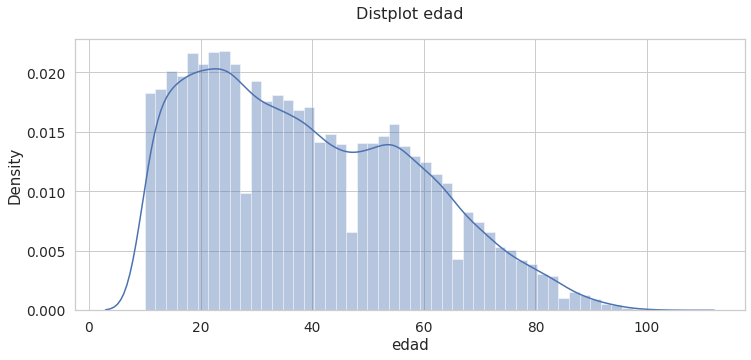

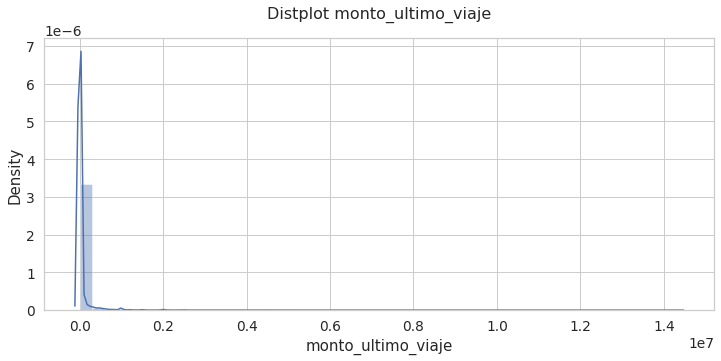

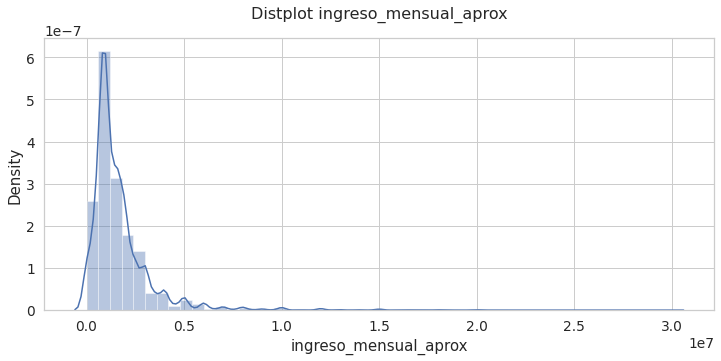

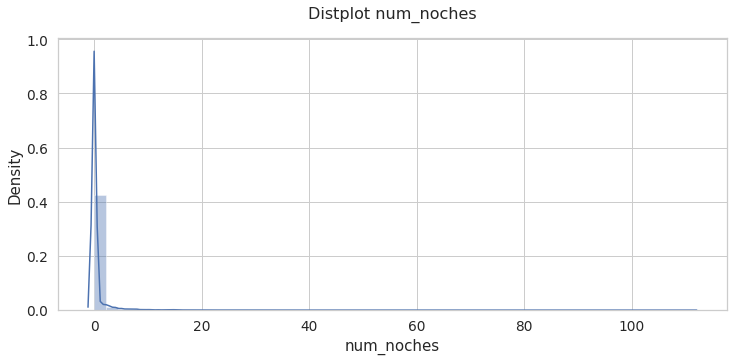

In [ ]:
for i in df_numerical.columns:
  plt.figure(figsize=(12,5))
  plt.title(f'Distplot {i}', fontsize=16)
  sns.distplot(df_numerical[i])
  plt.show()


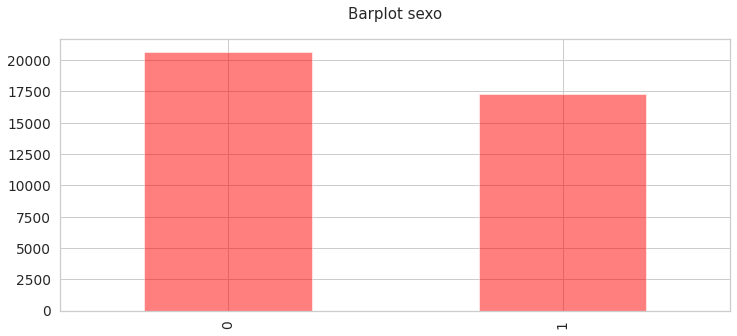

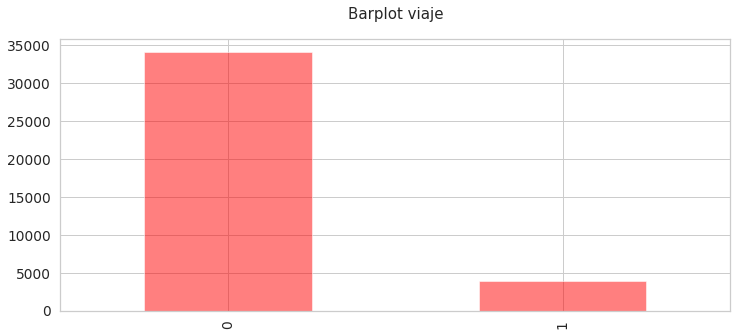

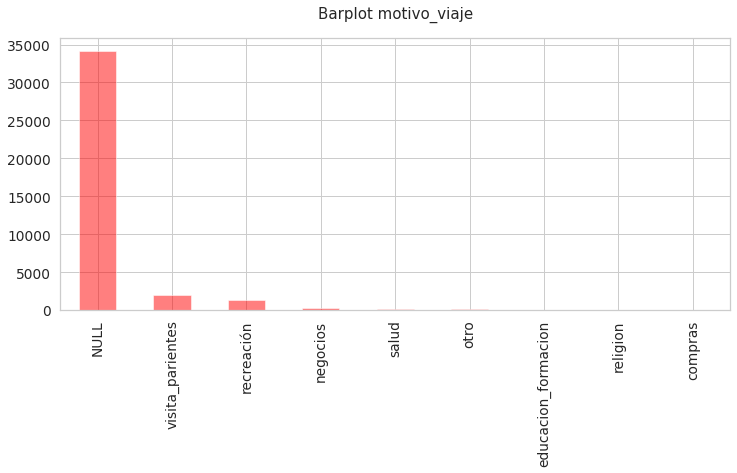

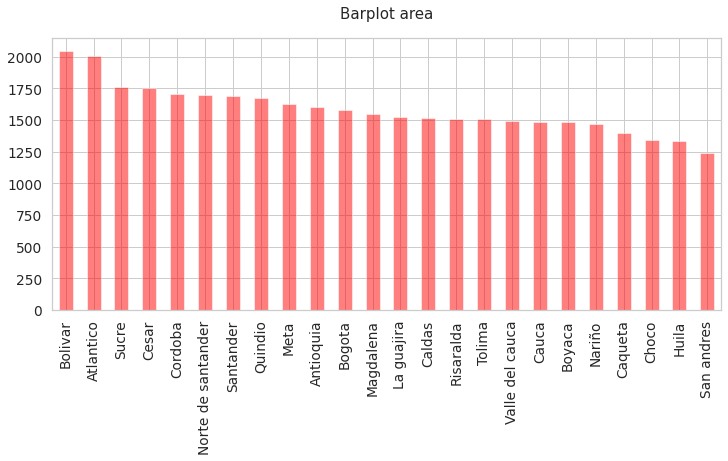

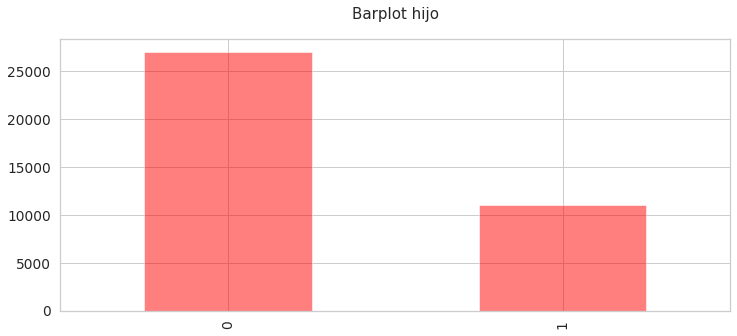

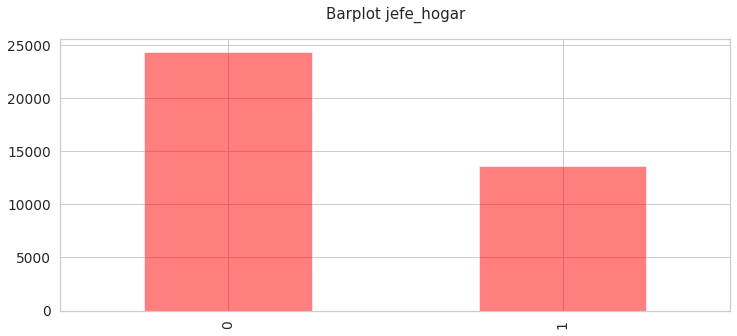

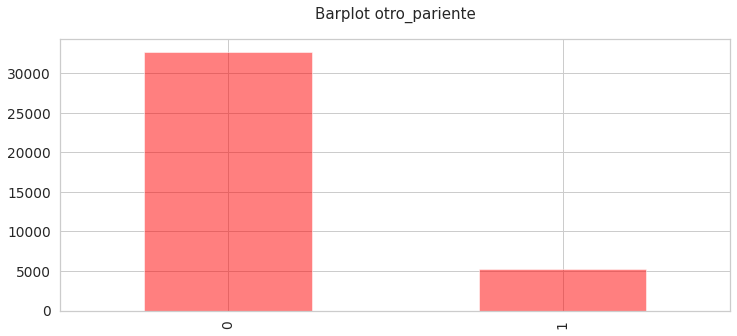

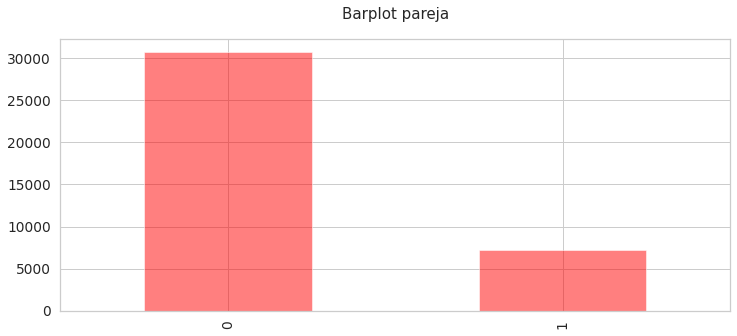

In [ ]:
for i in df_cat:
  plt.figure(figsize=(12,5))
  plt.title(f'Barplot {i}')
  df_cat[i].value_counts().plot(kind='bar',alpha = 0.5, color = 'red',)
  plt.show()



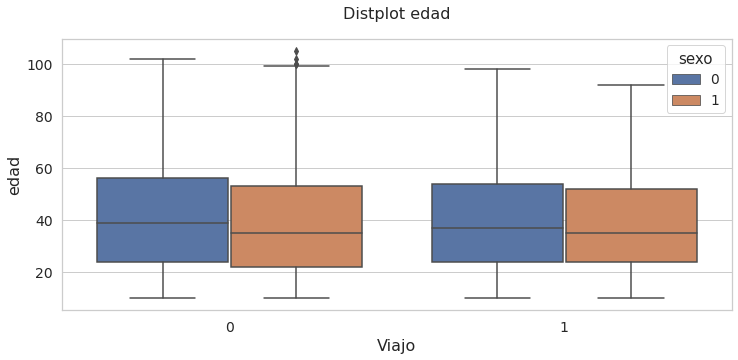

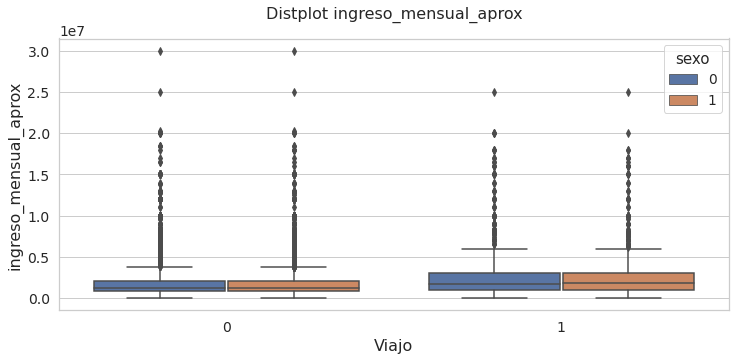

In [ ]:
for i in df_numerical[['edad','ingreso_mensual_aprox']].columns:
  plt.figure(figsize=(12,5))
  plt.title(f'Distplot {i}', fontsize=16)
  sns.boxplot(data=df,y=i,x='viaje',hue='sexo')
  plt.xlabel('Viajo',fontsize = 16)
  plt.xticks(fontsize = 14)
  plt.ylabel(i,fontsize = 16)
  plt.xticks(fontsize = 14)
  plt.yticks(fontsize = 14)
  plt.show()

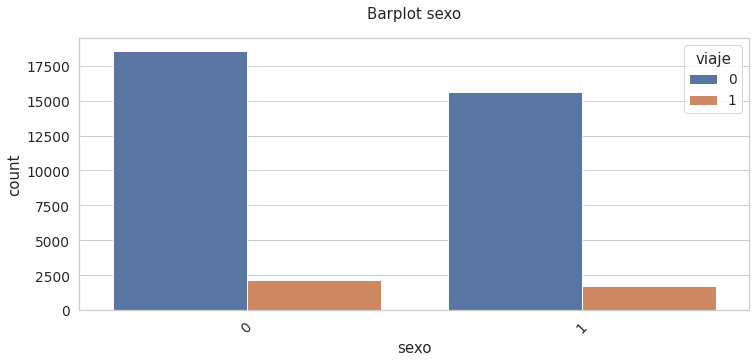

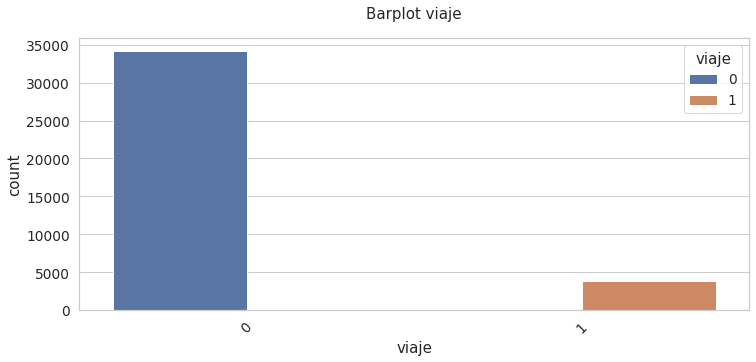

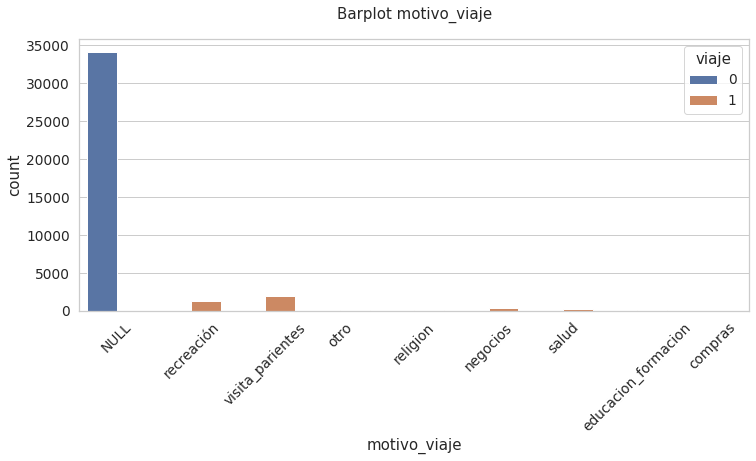

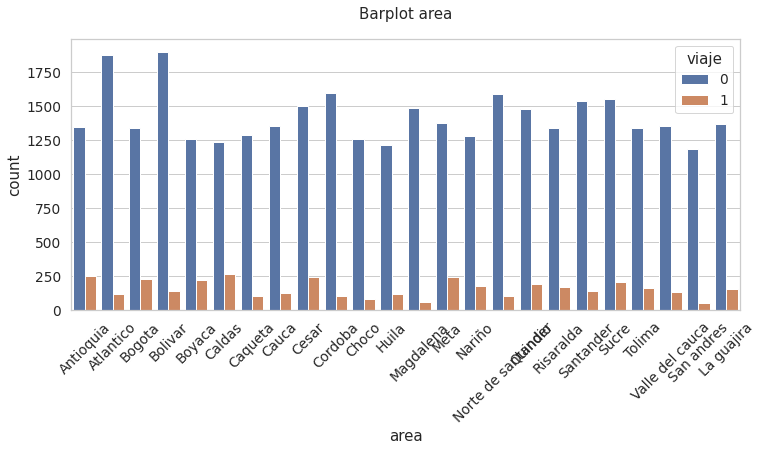

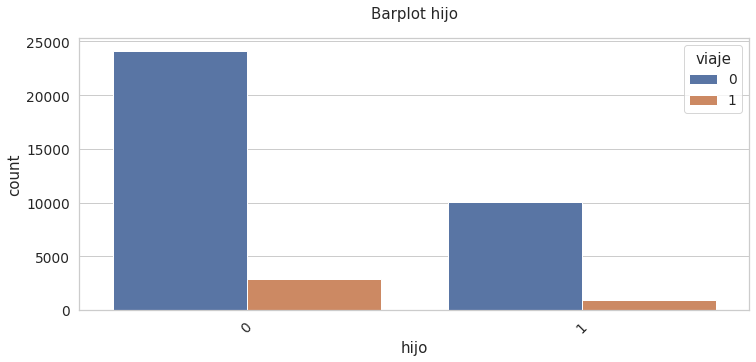

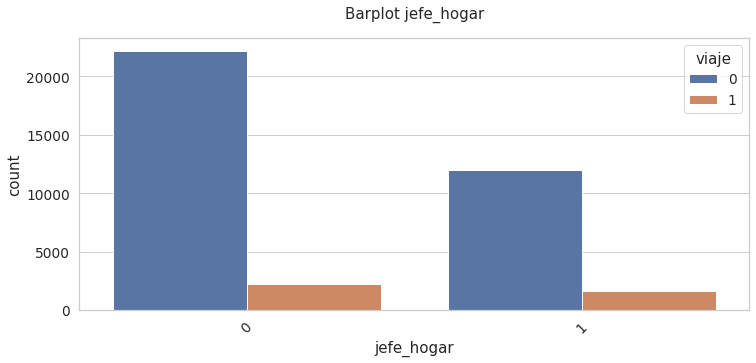

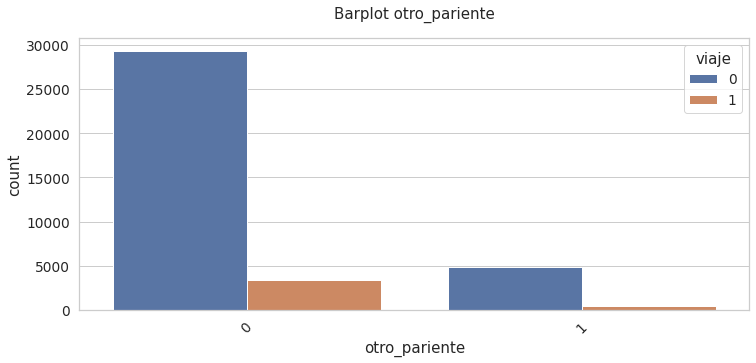

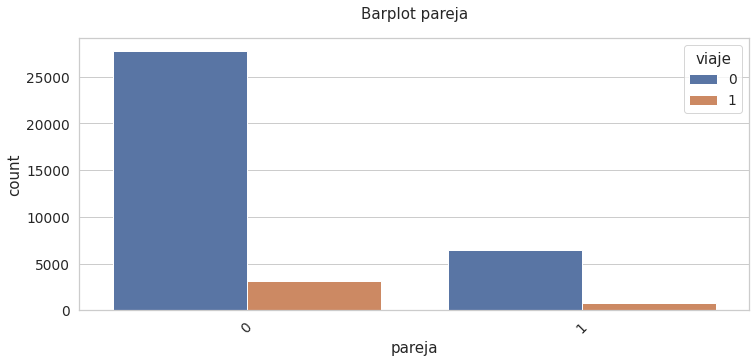

In [ ]:

sns.set(style='whitegrid', rc={"grid.linewidth": 0.1})  # Seaborn Style
sns.set_context("notebook", font_scale=1.25)            # More Seaborn Style
rcParams['axes.titlepad'] = 20   

for i in df_cat:
  plt.figure(figsize=(12,5))
  plt.title(f'Barplot {i}')
  sns.countplot(x=i,hue='viaje',data=df)
  plt.xticks(rotation=45)
  plt.show()


In [ ]:
df_viajeros = df[df['viaje'] == 1]
df_viajeros['area'] = df_viajeros['area'].str.upper()

In [ ]:
def dic_latitud():
    dic = {'BOGOTA':4.60971,'ANTIOQUIA':6.25184,'VALLE DEL CAUCA':3.43722,
    'ATLANTICO':10.96854,'SANTANDER':7.12539,'BOLIVAR':10.39972,'CORDOBA':8.74798,
    'NARIÑO':1.21361,'BOYACA':5.53528, 'MAGDALENA':11.24079, 'TOLIMA':4.43889,
    'NORTE DE SANTANDER':7.89391,'HUILA':2.9273,'CAUCA':2.43823,
    'CESAR':10.46314,'META':4.142,'SUCRE':9.30472,
    'RISARALDA':4.81333,'CALDAS':5.06889,'LA GUAJIRA':11.54444,
    'QUINDIO':4.53389,'CASANARE':5.33775,'CHOCO':5.69188,
    'CAQUETA':1.61438,'SAN ANDRES':12.58317}
    return dic  

def dic_longitud():
    dic = {'BOGOTA':-74.08175,
           'ANTIOQUIA':-75.56359,'VALLE DEL CAUCA':-76.5225,
    'ATLANTICO':-74.78132,'SANTANDER':-73.1198,'BOLIVAR':-75.51444,'CORDOBA':-75.88143,
    'NARIÑO':-77.28102,'BOYACA':-73.36778, 'MAGDALENA':-74.19904, 'TOLIMA':-75.23222,
    'NORTE DE SANTANDER':-72.50782,'HUILA':-75.28189,'CAUCA':-76.61316,
    'CESAR':-73.25322,'META':-73.62664,'SUCRE':-75.39778,
    'RISARALDA':-75.69611,'CALDAS':-75.51738,'LA GUAJIRA':-72.90722,
    'QUINDIO':-75.68111,'CASANARE':-72.39586,'CHOCO':-76.65835,
    'CAQUETA':-75.60623,'SAN ANDRES':-81.70636}
    return dic

In [ ]:
df_viajeros['latitud'] = df_viajeros['area'].replace(dic_latitud()) 
df_viajeros['longitud'] = df_viajeros['area'].replace(dic_longitud()) 

In [ ]:
stationArr = df_viajeros[['latitud', 'longitud']].to_numpy()

fol = folium.Map(location = [4.57, -74.08175],zoom_start = 6 )
fol.add_children(plugins.HeatMap(stationArr, radius=20)) # ploting the heatmap

fol

## **Aprendizaje No Supervisado**

In [ ]:
df_viajeros.head()

,sexo,edad,viaje,motivo_viaje,monto_ultimo_viaje,nivel_educativo,ingreso_mensual_aprox,num_noches,area,hijo,jefe_hogar,otro_pariente,pareja,mahal_distances,p_value,latitud,longitud
13,0,11,1,recreación,100000.0,11,850000.0,5,ANTIOQUIA,1,0,0,0,2.075072,1.0,6.25184,-75.56359
15,0,30,1,recreación,1100000.0,15,1000000.0,5,ANTIOQUIA,0,0,0,1,3.517307,1.0,6.25184,-75.56359
16,0,15,1,recreación,900000.0,9,1000000.0,5,ANTIOQUIA,1,0,0,0,3.146748,1.0,6.25184,-75.56359
17,1,12,1,recreación,900000.0,5,1000000.0,5,ANTIOQUIA,1,0,0,0,3.210826,1.0,6.25184,-75.56359
20,0,55,1,visita_parientes,50000.0,0,557000.0,7,ANTIOQUIA,0,1,0,0,2.444844,1.0,6.25184,-75.56359


**Seleccionamos varaibles relevantes para tomar la decision de viajar**

In [ ]:
df_viajeros = df_viajeros[['sexo','edad','nivel_educativo','ingreso_mensual_aprox']]

#### **Escalemos los datos...**

In [ ]:
X = df_viajeros.to_numpy()
scal = StandardScaler()
X_scal = scal.fit_transform(X)

#### **Kmeans**

In [ ]:
# vamos hacer un bucle para explorar el indice davies_bouldin_score por numero de cluster

scores = []
for i in range(2,12):
  kmeans = KMeans(n_clusters=i, random_state=777).fit(X_scal)
  labels = kmeans.labels_
  scores.append(davies_bouldin_score(X_scal, labels))

In [ ]:
scores

[1.53742075226383,
 1.2742745556812534,
 1.079438815669424,
 1.0239059740746665,
 0.9801734316269936,
 0.9393992272810304,
 0.922022094492092,
 0.9241521534684547,
 0.9524852574400114,
 0.9598032799553614]

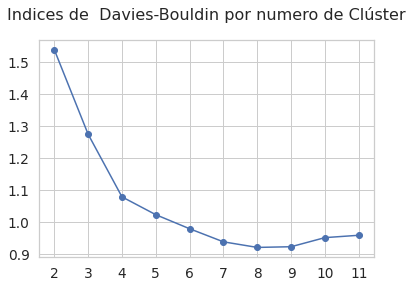

In [ ]:
plt.title('Indices de  Davies-Bouldin por numero de Clúster',fontsize=16)
plt.plot(range(2,12),scores)
plt.scatter(range(2,12),scores)
plt.xticks(range(2,12))
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=8, random_state=777).fit(X_scal)
y = kmeans.labels_

In [ ]:
df_viajeros['labels'] = y

**Podemos observar la frecuencia de observaciones que quedaron por grupo**

In [ ]:
df_viajeros['labels'].value_counts()

4    775
7    641
1    524
0    514
5    509
2    368
6    359
3    173
Name: labels, dtype: int64

## **Aprendizaje Supervisado - Clasificacion**

In [ ]:
df_modelo = df[['viaje','sexo','edad','nivel_educativo','ingreso_mensual_aprox','hijo','jefe_hogar','pareja','otro_pariente']]

In [ ]:
y = df_modelo[['viaje']].to_numpy()
X = df_modelo.drop(columns = 'viaje').to_numpy()

**Escalemos los datos**

In [ ]:
scal = StandardScaler()
X_scal = scal.fit_transform(X)

**Hacemos Split de los datos**

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_scal,y,test_size=0.3,random_state = 777)

In [ ]:
param_grid={'criterion':['gini', 'entropy'],
            'max_depth':[5,7,10,15],
            'max_features':['auto', 'sqrt', 'log2'],
            'bootstrap': [True, False]}

grid_search=GridSearchCV(RandomForestClassifier(),param_grid,cv=6) 
grid_search.fit(X_train,y_train)

grid_search.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto'}

In [ ]:
grid_search.best_params_


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto'}

In [ ]:
clf = RandomForestClassifier(**grid_search.best_params_, random_state = 777, class_weight = {0:0.1,1:0.9})
clf.fit(X_train,y_train)

RandomForestClassifier(class_weight={0: 0.1, 1: 0.9}, max_depth=5,
                       random_state=777)

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred,target_names=['No viajo','Viajo']))

              precision    recall  f1-score   support

    No viajo       0.94      0.66      0.77     10265
       Viajo       0.16      0.59      0.25      1130

    accuracy                           0.65     11395
   macro avg       0.55      0.62      0.51     11395
weighted avg       0.86      0.65      0.72     11395



**Pequeña Conclusion**

A el modelo le cuesta predecir a los individuos que viaja, en un principio sospecho que puede ser debido a la proporcion de viajeros contra no viajeros dentro de los datos, Tratamos de solucionar el problema con el parametro de peso por clase. 
